为了更直观地理解EM算法在混合线性模型中的应用，下面通过一个简单的数值模拟示例来展示算法的具体步骤。

#### **示例设定**

假设我们有以下混合线性模型：

$$
Y = X\beta + Zu + \epsilon
$$

其中：
- $ Y $ 是 $ n = 100 $ 个观测值。
- $ X $ 是 $ 100 \times 2 $ 的设计矩阵，包含截距和一个自变量。
- $ Z $ 是 $ 100 \times 1 $ 的设计矩阵（单个随机效应）。
- $ \beta $ 是 $ 2 \times 1 $ 的固定效应向量。
- $ u \sim \mathcal{N}(0, \sigma_u^2 G) $，其中 $ G = 1 $（标量）。
- $ \epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2 I_n) $。

假设真实参数为：
- $\beta = \begin{pmatrix} 1 \\ 2 \end{pmatrix}$
- $\sigma_u^2 = 1$
- $\sigma_\epsilon^2 = 2$
#### **数据生成**


In [3]:
import numpy as np

# 设置随机种子以确保可重复性
np.random.seed(0)

# 参数
n = 1000
p = 2
q = 1
beta_true = np.array([1, 2])
sigma_u2_true = 1.0
sigma_e2_true = 2.0
G = np.array([[1.0]])  # 随机效应协方差矩阵

# 设计矩阵
X = np.hstack((np.ones((n, 1)), np.random.randn(n, p-1)))
Z = np.random.randn(n, q)

# 随机效应和误差项
u = np.random.multivariate_normal(mean=np.zeros(q), cov=sigma_u2_true * G)
epsilon = np.random.normal(0, np.sqrt(sigma_e2_true), size=n)

# 响应变量
Y = X @ beta_true + Z @ u + epsilon

#### **EM算法实现**

In [4]:
# 初始化参数
beta = np.linalg.lstsq(X, Y, rcond=None)[0]
sigma_u2 = 1.0
sigma_e2 = 1.0
max_iter = 1000
epsilon = 1e-6

for iteration in range(max_iter):
    # E步
    Sigma_u = 1/sigma_u2 * np.linalg.inv(G) + 1/sigma_e2 * Z.T @ Z
    Sigma_u_inv = np.linalg.inv(Sigma_u)
    mu_u = Sigma_u_inv @ (1/sigma_e2 * Z.T @ (Y - X @ beta))
    E_uuT = Sigma_u_inv + np.outer(mu_u, mu_u)
    
    # M步
    beta_new = np.linalg.inv(X.T @ X) @ X.T @ (Y - Z @ mu_u)
    residual = Y - X @ beta_new
    sigma_e2_new = (residual.T @ residual - 2 * residual.T @ Z @ mu_u + np.trace(Z.T @ Z @ E_uuT)) / n
    sigma_u2_new = np.trace(np.linalg.inv(G) @ E_uuT) / q
    
    # 检查收敛
    if (np.linalg.norm(beta_new - beta) < epsilon and
        abs(sigma_e2_new - sigma_e2) < epsilon and
        abs(sigma_u2_new - sigma_u2) < epsilon):
        print(f"Converged at iteration {iteration}")
        break
    
    # 更新参数
    beta = beta_new
    sigma_e2 = sigma_e2_new
    sigma_u2 = sigma_u2_new

# 输出结果
print("Estimated β:", beta)
print("Estimated σ_u^2:", sigma_u2)
print("Estimated σ_ε^2:", sigma_e2)

Converged at iteration 3
Estimated β: [0.9343683  2.04127588]
Estimated σ_u^2: 2.4720099647348657
Estimated σ_ε^2: 1.8202438498165971


Text(0, 0.5, 'y-true')

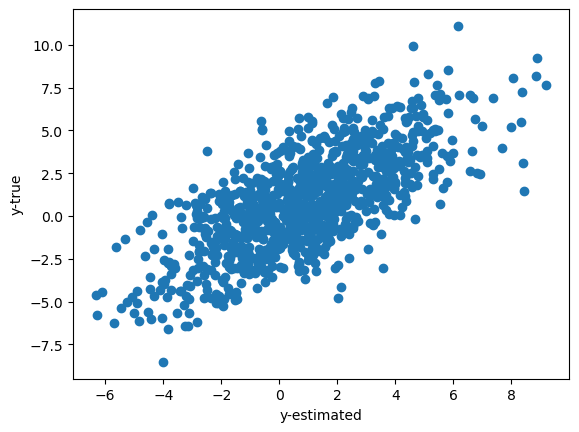

In [24]:
# 随机效应和误差项
u_estimated = np.random.multivariate_normal(mean=np.zeros(q), cov=sigma_u2 * G)
epsilon_estimated = np.random.normal(0, np.sqrt(sigma_e2), size=n)

Y_estimated = X @ beta  + Z @ u_estimated + epsilon_estimated
import matplotlib.pyplot as plt
plt.scatter(Y_estimated, Y)
plt.xlabel("y-estimated")
plt.ylabel("y-true")
